# A Vanilla Image Segmentaion Model to Understand Clouds from Satellite Images

## Introduction

A vanilla image segmentation model is applied on the image data of Kaggle competition, [Understanding Clouds from Satellite Images](https://www.kaggle.com/c/understanding_cloud_organization/). The motivation of this competition is described following:

```
Shallow clouds play a huge role in determining the Earth's climate. They’re also difficult to understand and to represent in climate models. By classifying different types of cloud organization, researchers at Max Planck hope to improve our physical understanding of these clouds, which in turn will help us build better climate models.
```

In [the published paper](https://arxiv.org/pdf/1906.01906.pdf), researchers divided the cloud formation into four patterns, Sugar, Flower, Fish and Gravel. Therefore, given a batch of labeled images, it is possible to train a image segementaion model to predict the labels of test image segmentation. Since four patterns are quite different, it is natural to train 4 different models to predict the pattern segmentation.

### Dataset notes 
Several items needed to notice as mentioned in [the evaluation metric](https://www.kaggle.com/c/understanding_cloud_organization/overview/evaluation):

- Both train/test images and train image mask are `1400 x 2100`, predicted image masks on test image `350 x 525`.


### Model notes
Several useful libraries are applied in this vanilla model:
- [albumentations](https://github.com/albu/albumentations): this is a python library for image augmentation.
- [catalyst](https://github.com/catalyst-team/catalyst): this is a python library that provide high-level pyTorch APIs.
- [segmentation_models_pytorch](https://github.com/qubvel/segmentation_models.pytorch): this is a library with convenient wrappers for models, losses and other useful things.
- [pytorch-toolbelt](https://github.com/BloodAxe/pytorch-toolbelt): this is a python library to build pytorch models with short-cut.

## Data analysis

In this chapter, a basic analysis features are provided.

### Packages setup

The package installation is one time setup.

In [1]:
!pip install catalyst
!pip install pretrainedmodels
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-7kodh0gl
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-7kodh0gl
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.0.3-cp36-none-any.whl size=27374 sha256=42ebaacfffea4846612ed333aa79b391ef9daf72af32ca0d6b691d830565a44d
  Stored in directory: /tmp/pip-ephem-wheel-cache-g9r_i6n5/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
Successfully built segmentation-models-pytorch


In [36]:
import os
import cv2
import collections
import time 
import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True

import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import torch as AT

from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.dl.runner import SupervisedRunner
from catalyst.contrib.models.segmentation import Unet
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback

import segmentation_models_pytorch as smp

In [37]:
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [38]:
class DatasetLoader():
    def __init__(self, base_path):
        self.base_path = base_path
        self.train_image_mask_filename = "train.csv"
        self.test_image_pred_sample_filename = "sample_submission.csv"
        self.train_image_dir = "train_images"
        self.test_image_dir = "test_images"
    
    def get_dataset_list(self):
        return os.listdir(self.base_path)
    
    def get_train_image_mask_as_pandas_df(self):
        df = pd.read_csv(f'{self.base_path}/train.csv')
        return df
    
    def get_test_image_pred_sample_as_pandas_df(self):
        df = pd.read_csv(f'{self.base_path}/sample_submission.csv')
        return df
    
    def get_train_image_list(self):
        return os.listdir(f'{self.base_path}/{self.train_image_dir}')

    def get_test_image_list(self):
        return os.listdir(f'{self.base_path}/{self.test_image_dir}')
    
    @staticmethod
    def __parse_filename(image_label):
        """
        input: image_label, for example, 0011165.jpg_Flower
        output: filename
        """
        tmp_list = image_label.split('_')
        if len(tmp_list) == 2:
            return tmp_list[0]
        else:
            return ""

    @staticmethod
    def __parse_label(image_label):
        """
        input: image_label, for example, 0011165.jpg_Flower
        output: label
        """
        tmp_list = image_label.split('_')
        if len(tmp_list) == 2:
            return tmp_list[1]
        else:
            return ""
        
    def etl_train_image_mask_df(self, raw_df):
        raw_df['filename'] = raw_df["Image_Label"].apply(self.__parse_filename)
        raw_df['label'] = raw_df["Image_Label"].apply(self.__parse_label)
        etl_df = raw_df.drop(columns=['Image_Label'])
        return etl_df
    
    @staticmethod
    def plot_pie_chart_from_pandas_series(series):
        plt.figure(figsize=(16,8))

        # plot chart
        ax1 = plt.subplot(121, aspect='equal')
        series.plot(kind='pie', ax=ax1, legend = True, fontsize=14)
        
        # plot table
        ax2 = plt.subplot(122)
        plt.axis('off')
        tbl = table(ax2, series, loc='center')
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(14)

        plt.show()

    def plot_images_from_pandas_df(self, etl_df):
        fig = plt.figure(figsize=(25, 16))
        for j, im_id in enumerate(np.random.choice(etl_df['filename'].unique(), 4)):
            for i, (idx, row) in enumerate(etl_df.loc[etl_df['filename'] == im_id].iterrows()):
                ax = fig.add_subplot(5, 4, j * 4 + i + 1, xticks=[], yticks=[])
                im = Image.open(f"{self.base_path}/{self.train_image_dir}/{row['filename']}")
                plt.imshow(im)
                mask_rle = row['EncodedPixels']
                try: # label might not be there!
                    mask = rle_decode(mask_rle)
                except:
                    mask = np.zeros((1400, 2100))
                plt.imshow(mask, alpha=0.5, cmap='gray')
                ax.set_title(f"Image: {row['filename']}. Label: {row['label']}")

In [39]:
dataset_loader = DatasetLoader("../data")

In [40]:
# list dataset
dataset_loader.get_dataset_list()

['train_images', 'train.csv', 'sample_submission.csv', 'test_images']

In [41]:
# load and investigate train image mask dataframe
train_image_mask_df = dataset_loader.get_train_image_mask_as_pandas_df()
train_image_mask_df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [42]:
# load and investigate test image prediction sample dataframe
test_image_pred_sample_df = dataset_loader.get_test_image_pred_sample_as_pandas_df()
test_image_pred_sample_df.head()

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,1 1
1,002f507.jpg_Flower,1 1
2,002f507.jpg_Gravel,1 1
3,002f507.jpg_Sugar,1 1
4,0035ae9.jpg_Fish,1 1


In [43]:
# investigate statistics on train/test image
train_image_list = dataset_loader.get_train_image_list()
test_image_list = dataset_loader.get_test_image_list()

print(f'There are {len(train_image_list)} images in train dataset')
print(f'There are {len(test_image_list)} images in test dataset')

There are 5546 images in train dataset
There are 3698 images in test dataset


In [44]:
# etl on train image mask dataframe
etl_train_image_mask_df = dataset_loader.etl_train_image_mask_df(train_image_mask_df)
etl_train_image_mask_df.head()

,EncodedPixels,filename,label
0,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
2,NaN,0011165.jpg,Gravel
3,NaN,0011165.jpg,Sugar
4,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish


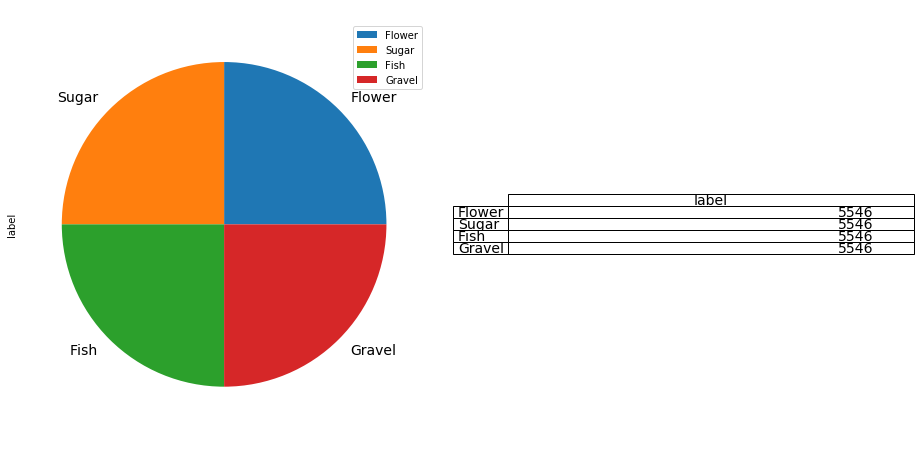

In [45]:
# sanity check: image count by label
dataset_loader.plot_pie_chart_from_pandas_series(etl_train_image_mask_df["label"].value_counts())

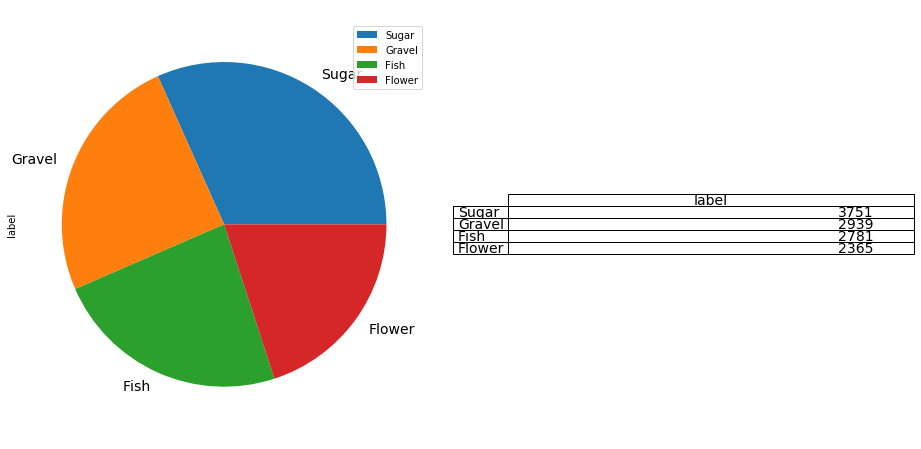

In [46]:
# sanity check: image count by label with pixel
dataset_loader.plot_pie_chart_from_pandas_series(etl_train_image_mask_df.loc[etl_train_image_mask_df['EncodedPixels'].isnull() == False, 'label'].value_counts())

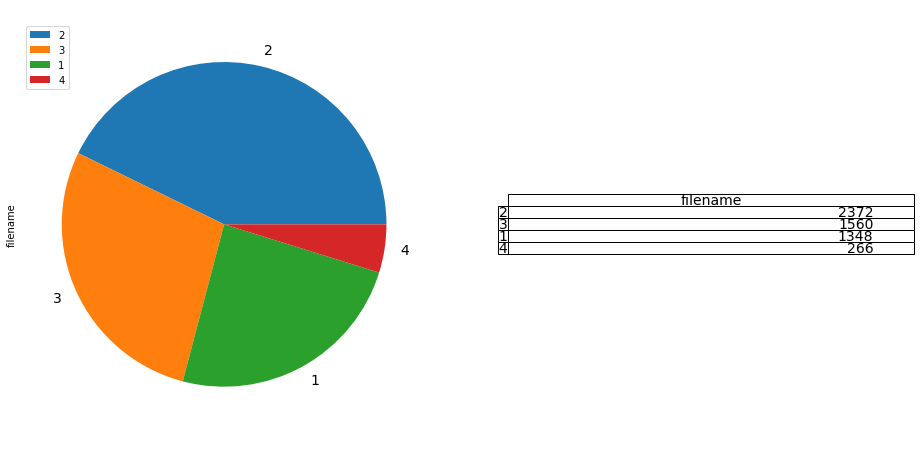

In [47]:
# sanity check: filename count by number of labels
dataset_loader.plot_pie_chart_from_pandas_series(etl_train_image_mask_df.loc[etl_train_image_mask_df['EncodedPixels'].isnull() == False, 'filename'].value_counts().value_counts())

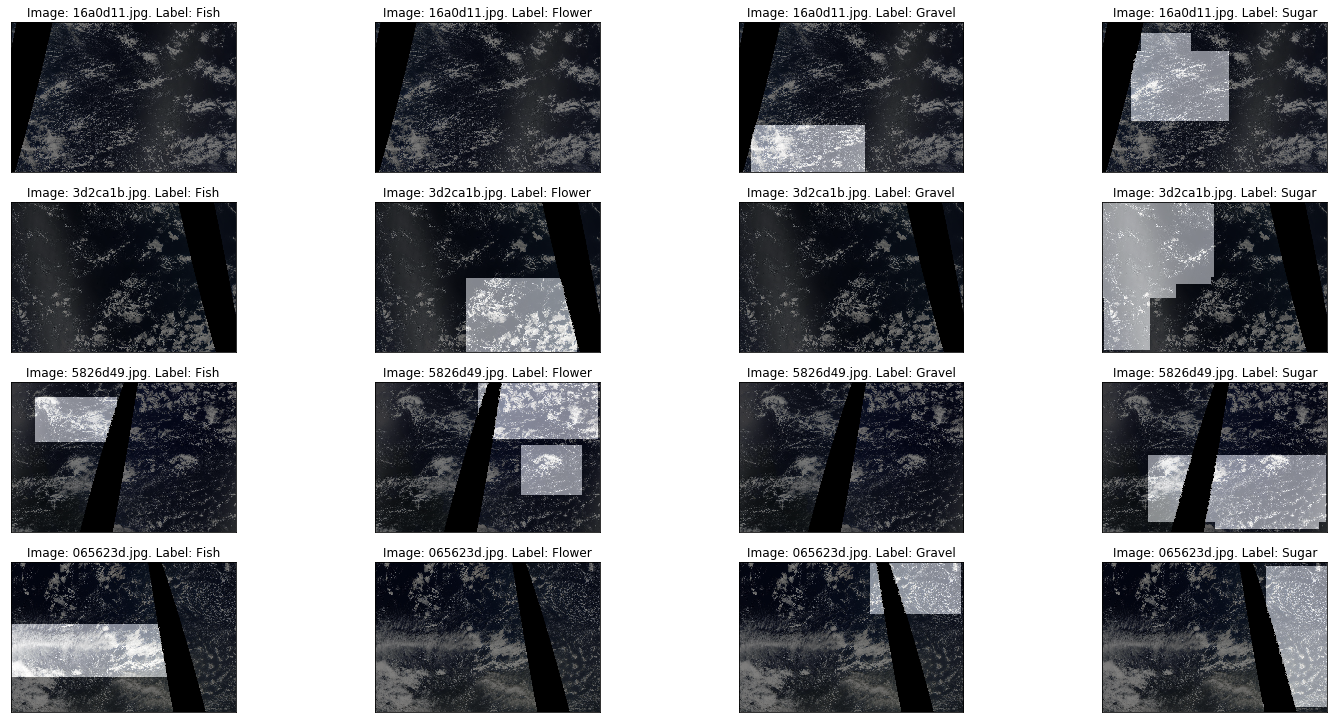

In [48]:
# sanity check: display image samples grouped by label
dataset_loader.plot_images_from_pandas_df(etl_train_image_mask_df)

### Data wrangling
Dataset ETL for model trainning